# COMP47590 Advanced Machine Learning
# Fine Tuning a Pre-trained Model


In this example we build a Convolutional Neural Network with **PyTorch**  to classify images that are stored locally. The dataset used is from Kaggle: 
* cats vs dogs https://www.kaggle.com/c/dogs-vs-cats

This example uses fine tunes a VGG-16 model pre-trained on the Imagenet dataset. 

In [5]:
import os 
import csv
import random
import numpy as np
import pandas as pd

from sklearn import metrics

import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import torch.optim as optim
from torchvision.models import vgg16, VGG16_Weights

import matplotlib.pyplot as plt
%matplotlib inline 

## Data Loading & Pre-processing
Set up the dataset loading and pre-processing process. We provide the name of a folder containing images. We assume that he images of different classes are contained in folders with class ids.

In [6]:
# Dataset name
dataset_name = 'dogs-vs-cats'

# A sampling rate to allow undersampling for fast execuation
sample_rate = 0.1

# Define proportion of data for test, train and validation splits. 
train_split = 0.5
valid_split = 0.2
test_split = 0.3

# Desired dimensions of our images.
img_width, img_height = 128, 128

Define a Pytorch transformation to resize images to a standard size and convert them to a tensor representation. 

In [7]:
# Define the transforms
transformations = transforms.Compose([
    transforms.Resize((img_width, img_height)),

    transforms.ToTensor(), # Convert the image to a PyTorch Tensor.
])

In [8]:
# Load the data
dataset = datasets.ImageFolder("../Data/" + dataset_name + "/", transform = transformations)

# Resample the data set
resampled_size = int(sample_rate * len(dataset))
resampled_dataset, _ = random_split(dataset, [resampled_size, len(dataset) - resampled_size])

# Split the data into train, validation and test sets
test_size = int(test_split * len(resampled_dataset))
train_val_size = int(0.7 * len(resampled_dataset))
train_val_size = len(resampled_dataset) - test_size
train_val_dataset, test_dataset = random_split(resampled_dataset, [train_val_size, test_size])

train_size = int((train_split/(train_split + valid_split)) * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

Create Pytorch **DataLoader** objects to stream train, validation, and test sets. 

In [9]:
batch_size = 32  # Batch size used during training

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

Print a few randomly sampled example images.

In [10]:
items = iter(train_loader)
image, label = next(items)

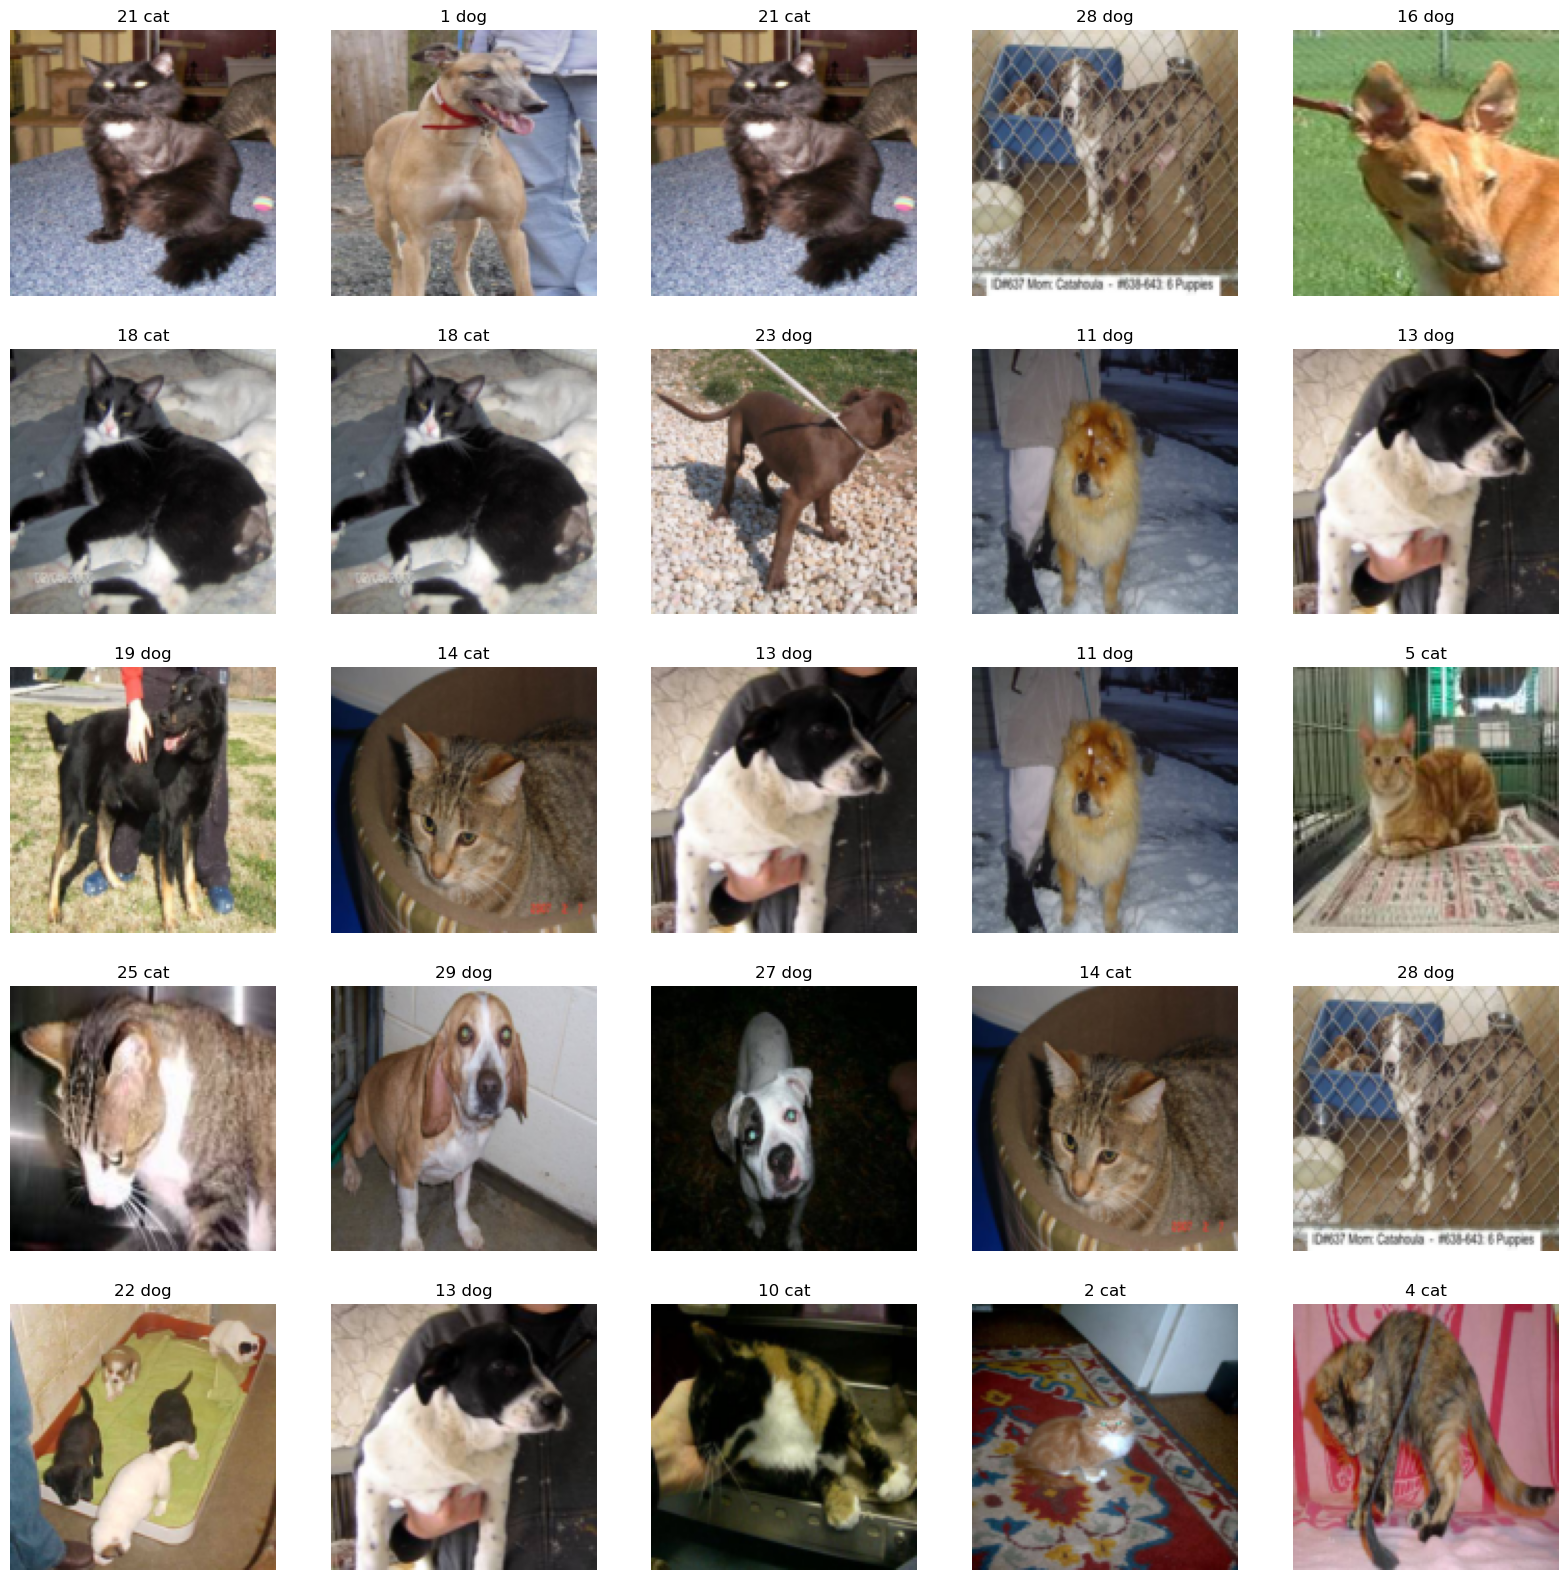

In [11]:
pltsize=4
row_images = 5
col_images = 5
label_names = dataset.classes
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(row_images * col_images):
    i_rand = random.randint(0, len(image)-1)
    np_image = image.numpy()
    np_label = label.numpy()
    plt.subplot(row_images,col_images,i+1)
    plt.axis('off')
    plt.imshow(np.transpose(np_image[i_rand], (1, 2, 0)))
    plt.title((str(i_rand) + " " + label_names[np_label[i_rand]]))

plt.show()

## Define Model

First load a **VGG-16 model** pre-trained on the Image Net dataset. 

In [12]:
model = vgg16(weights=VGG16_Weights.DEFAULT)

Freeze the weights of the pre-trained layers

In [13]:
for param in model.parameters():
    param.requires_grad = False

Get the input size of the fully connected layer

In [14]:
input_size = model.classifier[0].in_features

Replace the fully connected layers.

In [15]:
num_classes = len(dataset.classes)
model.classifier = nn.Sequential(
    nn.Linear(input_size, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(4096, num_classes)
)

In [16]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Train Model

Define the model training loop keeping track of some key attributes along the way. 

In [17]:
epochs = 2

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define lists to store the training and validation loss and accuracy for each epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()

    # Initialize the training loss and accuracy for this epoch
    running_train_loss = 0.0
    running_train_corrects = 0

    running_val_loss = 0.0
    running_val_corrects = 0

    for i, (X_train, y_train) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        # Compute statistics
        running_train_loss += loss.item() * batch_size
        running_train_corrects += torch.sum(torch.argmax(outputs, dim=1) == y_train)
    
    # Compute statistics for the entire epoch
    epoch_train_loss = running_train_loss / train_size
    epoch_train_acc = running_train_corrects.item() / train_size * 100

    # Append the training statistics to the lists
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # Evaluation on validation set
    with torch.no_grad():
        for i, (X_val, y_val) in enumerate(val_loader):
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            val_corrects = torch.sum(torch.argmax(val_outputs, dim=1) == y_val)

            # Compute statistics
            running_val_loss += val_loss.item() * batch_size
            running_val_corrects += torch.sum(torch.argmax(val_outputs, dim=1) == y_val)

              
    # Compute statistics for the entire epoch
    epoch_val_loss = running_val_loss / val_size
    epoch_val_acc = running_val_corrects.item() / val_size * 100

    # Append the validation statistics to the lists
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_acc:.2f}%, \
          Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.2f}%')

Epoch 1/2, Training Loss: 5.8757, Training Accuracy: 80.00%,           Validation Loss: 0.2480, Validation Accuracy: 88.60%
Epoch 2/2, Training Loss: 0.1712, Training Accuracy: 93.92%,           Validation Loss: 0.2689, Validation Accuracy: 92.40%


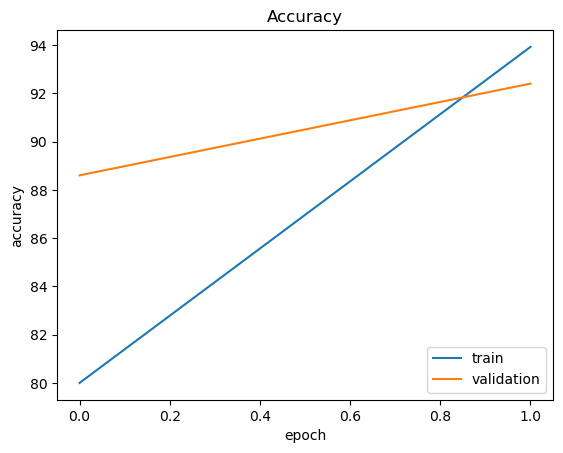

In [18]:
# Summarize history for accuracy
plt.plot(train_accuracies)
plt.plot(val_accuracies)
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
#plt.ylim((0, 1.1))
plt.show()

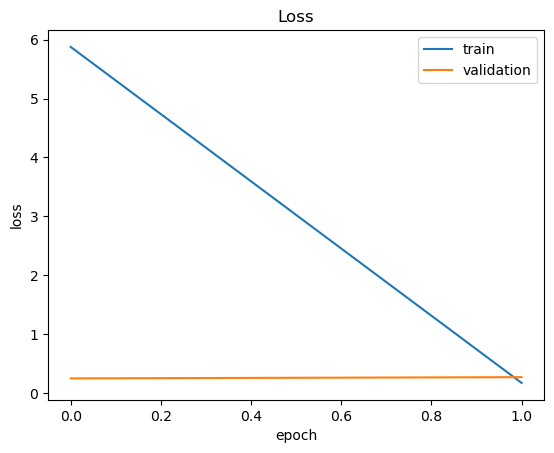

In [19]:
# Summarize history for loss
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
# plt.ylim((-0.1, 1.2))
plt.show()

## Evaluate Model

Generate some simple summary statistics of model performance. 

In [20]:
X_test_cat = []
y_true = []
y_pred = []
for i, (X_test, y_test) in enumerate(test_loader):
    test_outputs = model(X_test)
    _, preds = torch.max(test_outputs, 1)

    # Add up the predictions
    X_test_cat.extend(X_test)
    y_true.extend(y_test)
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
# Print performance details
print(metrics.classification_report(y_true, y_pred))

# Print confusion matrix 
print("Confusion Matrix")
display(pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       365
           1       0.95      0.87      0.91       385

    accuracy                           0.91       750
   macro avg       0.91      0.91      0.91       750
weighted avg       0.91      0.91      0.91       750

Confusion Matrix


Predicted    0    1  All
True                    
0          346   19  365
1           51  334  385
All        397  353  750

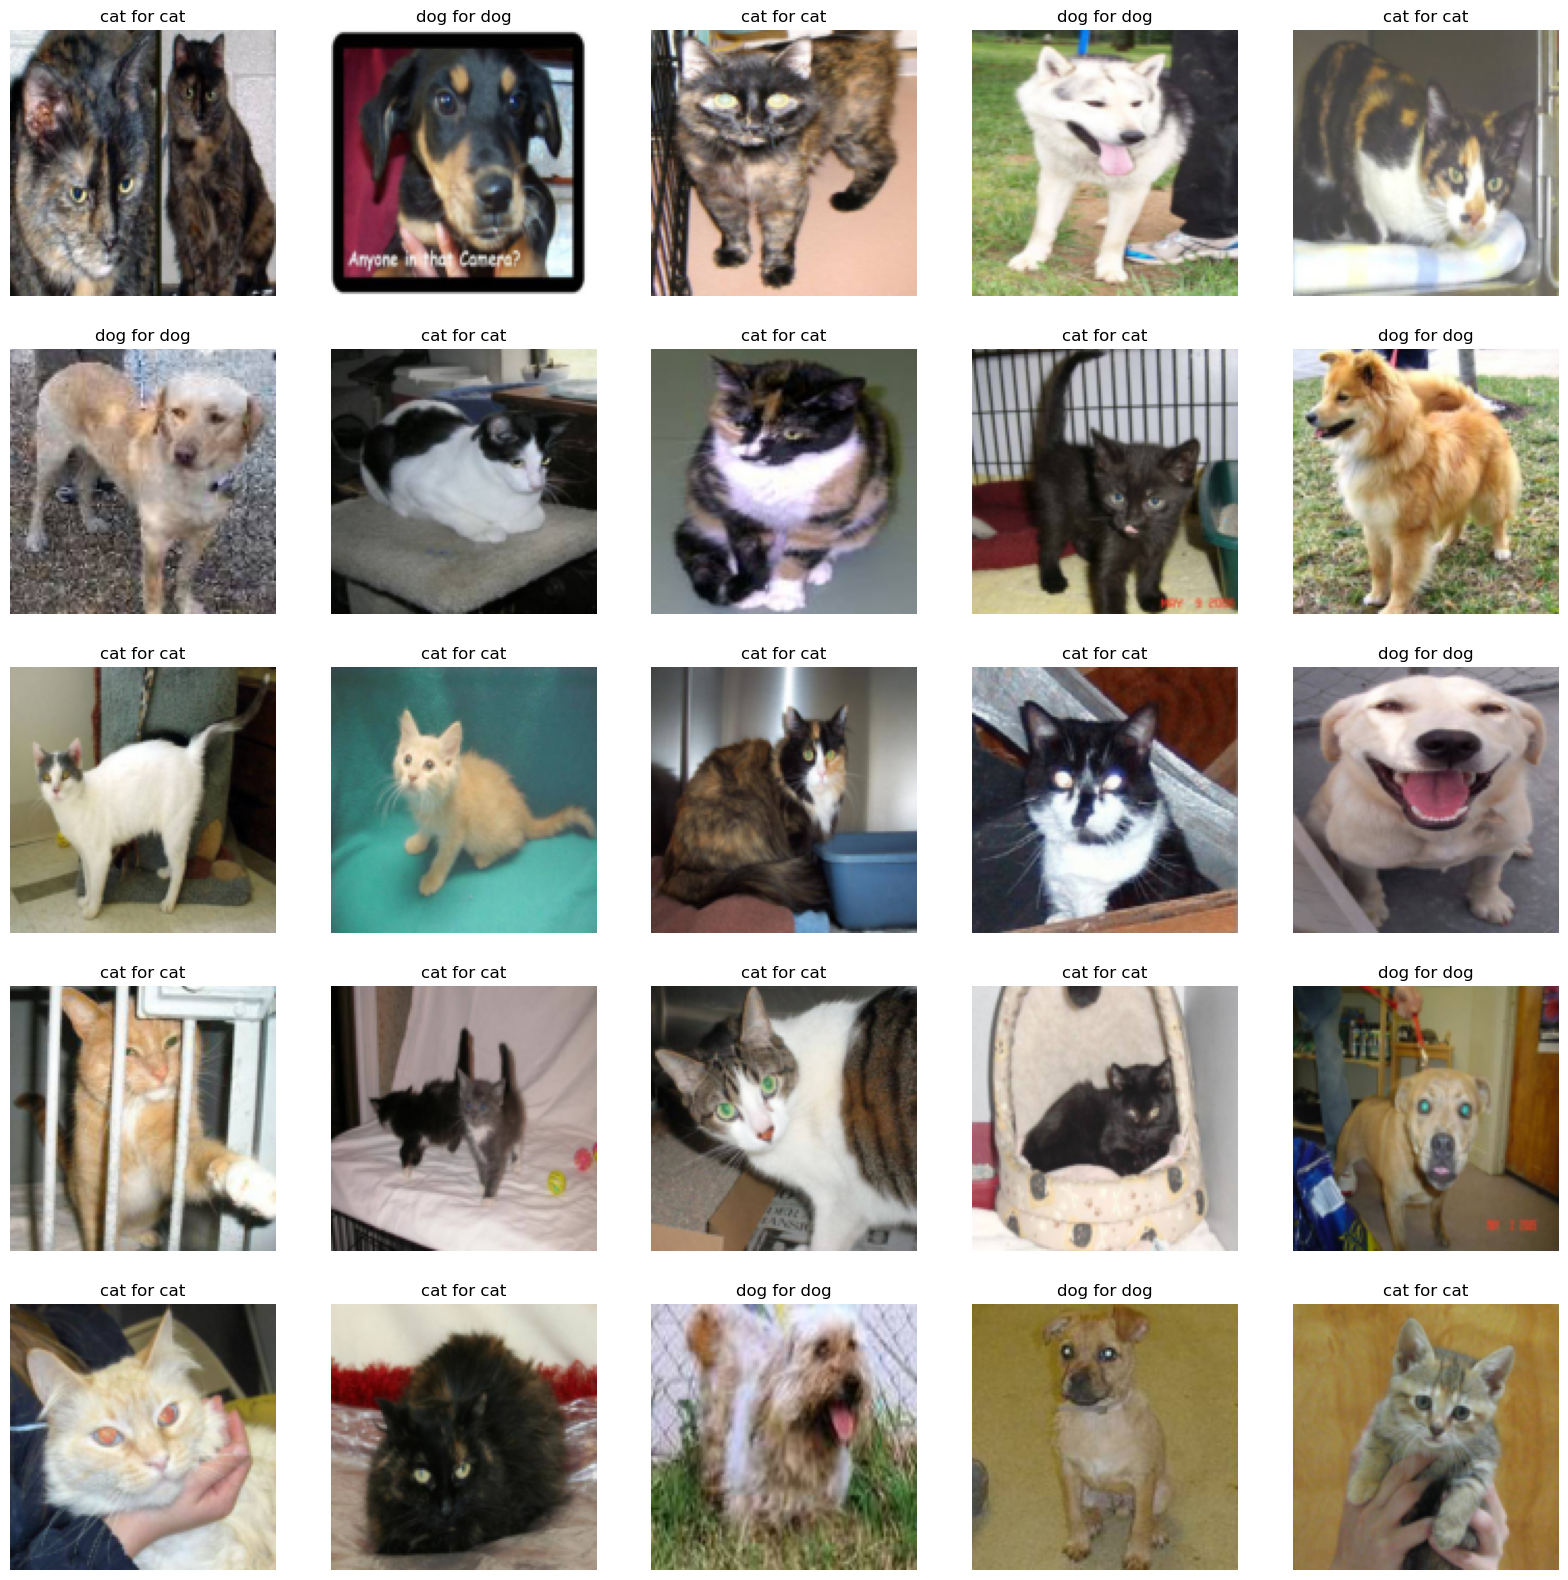

In [21]:
pltsize=4
row_images = 5
col_images = 5

maxtoshow = row_images * col_images
corrects = y_pred == y_true
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(test_size):
    if ii>=maxtoshow:
        break
    if (corrects[i]):
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(np.transpose(X_test_cat[i], (1, 2, 0)))
        plt.title("{} for {}".format(label_names[y_pred[i]], label_names[y_true[i]]))
        ii = ii + 1

plt.show()

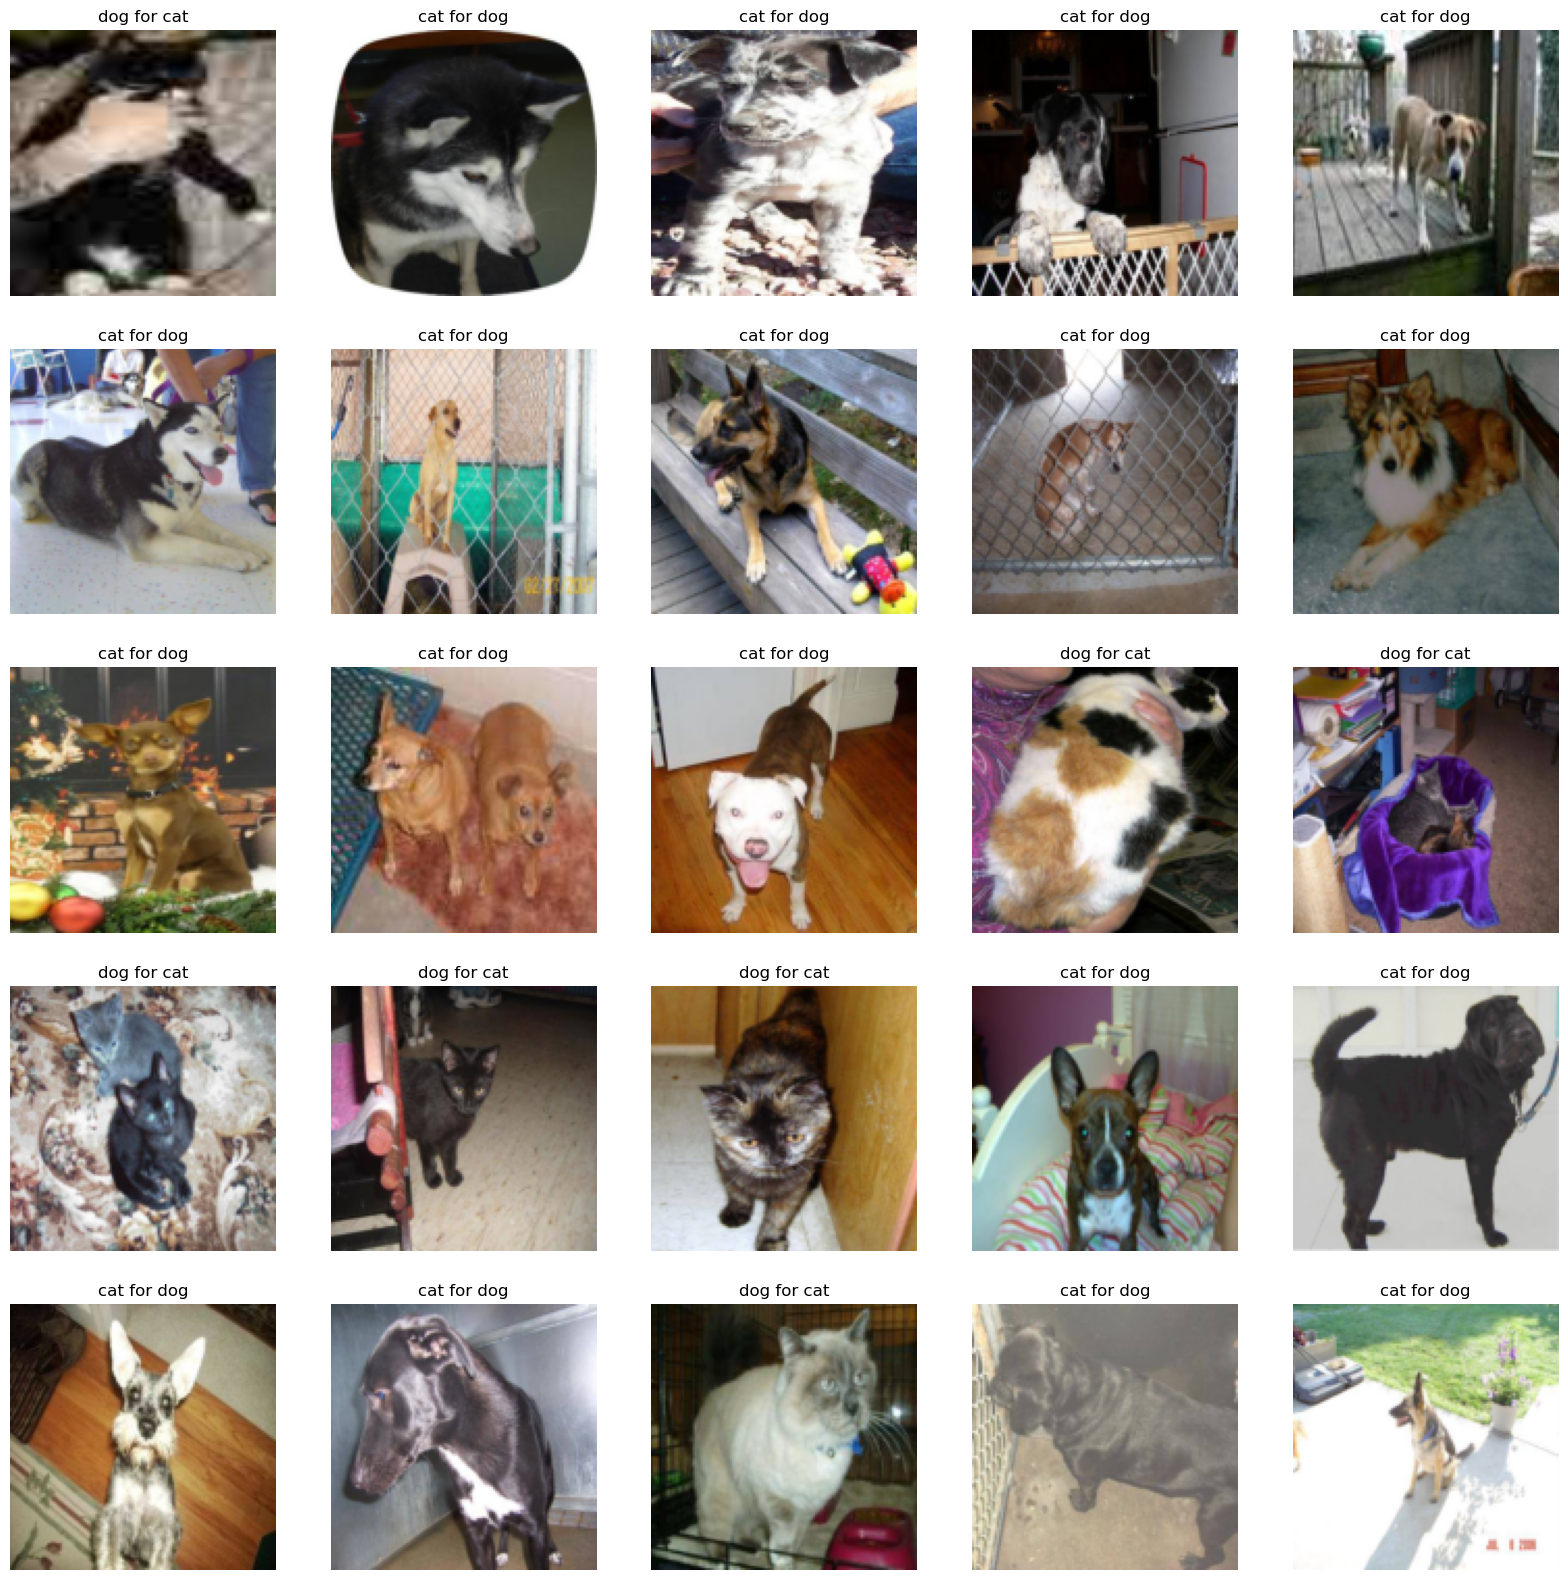

In [22]:
pltsize=4
row_images = 5
col_images = 5

maxtoshow = row_images * col_images
errors = y_pred != y_true
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(test_size):
    if ii>=maxtoshow:
        break
    if (errors[i]):
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(np.transpose(X_test_cat[i], (1, 2, 0)))
        plt.title("{} for {}".format(label_names[y_pred[i]], label_names[y_true[i]]))
        ii = ii + 1

plt.show()